In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importamos las funciones del archivo sample_extraction
#'/proximity vars/DistanceToUA.sdat'
path = '/content/drive/MyDrive/Certamen/Normalized' #./Normalized'
DATA_DIR = path
NDV = -99999 # No data value

#Librerías y funciones

In [ ]:
import gdal
import numpy as np
import pandas as pd
import random
from osgeo import gdal_array
from sklearn.feature_extraction import image
import itertools, random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score,precision_score, recall_score
import seaborn as sns
from tensorflow import keras
from keras.layers.core import Dropout
from keras.regularizers import L1L2
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.model_selection import KFold
import keras.backend as K



In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 102kB 4.4MB/s 


In [ ]:
def lr_schedule(l_r):
  return tf.keras.optimizers.schedules.InverseTimeDecay(l_r, decay_steps=1*10, decay_rate=1)
def SGD(lr_schedulee):
  return tf.keras.optimizers.SGD(lr_schedulee)
def Adam1(lr_schedulee):
  return tf.keras.optimizers.Adam(lr_schedulee)


In [ ]:
seed_value = 0
import random
random.seed(seed_value)

In [ ]:
def load_variables(year, month):
    # Mapa base para proyeccion y bounding box al pasar de .npy a .tif
    raster_base = gdal.Open(DATA_DIR + '/proximity vars/DistanceToUA.sdat')

    # VARIABLES
    # ----------
    #7 variables climáticas
    CLIMATIC_DIR = DATA_DIR + "/climatic vars/" 
    load_climatic = lambda ext:  gdal_array.LoadFile('{}{}{}{}'.format(CLIMATIC_DIR, year, month, ext))

    tmax = load_climatic("tx.tif")                                                                #1
    tmin = load_climatic("tn.tif")                                                                #2
    windspeed = load_climatic("ws.tif")                                                           #3
    prec = load_climatic("rn.tif")                                                                #4
    aet = load_climatic("aet.tif")                                                                #5
    cwd = load_climatic("cwd.tif")                                                                #6
    ndvi = load_climatic("NDVI.tif")                                                              #7 +++

    #4 variables topograficas
    TOPOGRAPHIC_DIR = DATA_DIR + "/_normalized topographic/"                                      
    load_topographic = lambda f:  gdal_array.LoadFile('{}{}'.format(TOPOGRAPHIC_DIR, f))          

    aspect = load_topographic('Aspect.sdat')                                                      #8 +++
    slope = load_topographic('Slope.sdat')                                                        #9 +++
    elev = load_topographic('Elevation.sdat')                                                     #10 +++
    surface = load_topographic('SurfaceRoughness.sdat')                                           #11

    #3 variables de proximidad
    PROXIMITY_DIR = DATA_DIR + "/proximity vars/"
    load_proximity = lambda f:  gdal_array.LoadFile('{}{}'.format(PROXIMITY_DIR, f))

    distroads = load_proximity('DistanceToRoads.sdat')                                            #12
    distrivers = load_proximity('DistanceToWater.sdat')                                           #13
    distUA = load_proximity('DistanceToUA.sdat')                                                  #14

    #6 clases variable land cover
    LAND_COVER = DATA_DIR + "/land cover vars/" 
    load_land = lambda clase,ext:  gdal_array.LoadFile('{}{}-{}{}'.format(LAND_COVER, year,clase,ext))
    c_1 = load_land('C1','.tif')                                                                   #15
    c_2 = load_land('C2','.tif')                                                                   #16
    c_3 = load_land('C3','.tif')                                                                   #17
    c_4 = load_land('C4','.tif')                                                                   #18
    c_5 = load_land('C5','.tif')                                                                   #19
    c_6 = load_land('C6','.tif')                                                                   #20

    # Raster con las clases (1 = incendio, 0 = no incendio)
    ignition_class = gdal_array.LoadFile(DATA_DIR + "/Ignition rasters/IF{}{}.sdat".format(year, month)) #0

    #Stack de las capas (variables + raster de clases)
    Stack = np.dstack((ignition_class,tmax,tmin,windspeed,prec,aet, cwd, ndvi, aspect, slope, elev, surface, distroads, distrivers, distUA,c_1,c_2,c_3,c_4,c_5,c_6))

    return Stack

FASE DE ENTRENAMEINTO

In [ ]:
import gdal
import numpy as np
import random
from osgeo import gdal_array
from sklearn.feature_extraction import image
import itertools, random

def CreateGeoTiff(Name, Array, driver, NDV, DataType, base, samplesize):
    Array[np.isnan(Array)] = NDV
    driver = gdal.GetDriverByName(driver)
    DataSet = driver.Create(Name, samplesize, samplesize, 15, eType=gdal.GDT_Float32)
    Geotr = base.GetGeoTransform()
    proj = base.GetProjection()
    DataSet.SetGeoTransform(Geotr)
    DataSet.SetProjection(proj)
    for i, image in enumerate(Array, 1):
        DataSet.GetRasterBand(i).WriteArray(image)
        DataSet.GetRasterBand(i).SetNoDataValue(NDV)
    DataSet.FlushCache()
    return Name

def select(size, pair_size): #Generar coorenadas aleatorias de tamaño pair_size, en el rango size. ejemplo: select(15,2) genera una lista de coordenadas ( x1,x2), con x1 y x2 en el rango(15). 
    g = itertools.permutations(range(size), pair_size)
    random_pairs = list(g)
    random.shuffle(random_pairs)
    return random_pairs

def search(Matriz_inicial, x, y, cover, patchsize, search_level):
    """
    No-fire sample search

    search_level = 0 considera un area de (3 x patchsize) x (3 x patchsize)
    search_level = 1 considera un area de (5 x patchsize) x (5 x patchsize)
    search_level = 2 lo mismo pero 7x
    search_level = 3 lo mismo pero 9x
    search_level = 4 lo mismo pero 11x
    """
    centroid = int(patchsize / 2 - 0.5)

    if search_level == 0:
        #primero se establece el area de busqueda (limitado al maximo de los margenes del area total)
        # El área de búsqueda no varía, pero su distribución depende de donde esté ubicada la muestra seleccionada, de ahí los condicionales
        # En el 1er caso, como la muestra está "esquinada" semi o completamente dentro del ráster completo , el área queda distribuida hacia arriba y hacia abajo de la muestra de forma fija,
        # en el caso de patchsize = 7, el área queda [0:21 ,...]
        if x < patchsize: a = patchsize # Muestra esquinada semi o completamente [superior izquierda o inferior izquierda], distribución del área fija [0:21,...]
        elif x > 550 - 2 * patchsize: a = 550 - 2 * patchsize 
        else: a = x # Muestra no esquinada [...,....]
        if y < patchsize: b = patchsize # Muestra esquinada semi o completamente [superior derecha o inferior derecha], distribución del área fija [..., 0:21]
        elif y > 480 - 2 * patchsize: b = 480 - 2 * patchsize
        else: b = y
        area1 = Matriz_inicial[a - patchsize : a + (2 * patchsize), b - patchsize : b + (2 * patchsize), :] #Selecciona área en donde se buscaran aleatoriamente centroides clase 0 
        pairs = select(area1.shape[0] - patchsize + 1, 2) # (area1.shape[0] = 7)
        #pairs: lista de coordenadas aleatorias de centroides en el area de estudio para samplear la muestra
        for t in range(len(pairs)):
            i = pairs[t][0]
            j = pairs[t][1]
            randompatch = area1[i:i + patchsize, j:j + patchsize, :] # Muestra seleccionada en el área (Incluye todos los rasters)
            ignition_raster = area1[i:i + patchsize, j:j + patchsize, 0] # Muestra seleccioanda en el área (Solo de la clase incendio)
            countzero = np.count_nonzero(ignition_raster) # Cuenta los valores distintos de 0 en la muestra seleccionada de la clase incendio (verifica si hay o no incendios en la muestra)
            if countzero==0 and cover[a-patchsize+i+centroid, b-patchsize+j+centroid] == 0: # Si no hay incendios en la muestra seleccionada, y esa muestra no se ha seleccionado antes, se selecciona dicha muestra
                #patch=np.squeeze(randompatch) # comprime las dimensiones con valor 1
                patch = randompatch
                cover[a-patchsize+i+centroid, b-patchsize+j+centroid] = 2 # Asigna con valor 2 el centroide de la muestra seleccionada, para no volverla a seleccionar, el 2 indica que es de clase 0.
                return patch, cover #Retorna el patch0 (patch de clase 0) seleccionado, junto con la matriz de 0 que representa los centroides de las muestras seleccionadas hasta el momento (1 incendio, 2 no incendio)
            elif t == (len(pairs)-1): # Si es que no encuentra ninguna muestra clase 0 en el área especificada, en este caso (3 x patchsize)x( 3x patchsize)
                search_level = 1 # Aumenta el rango de búsqueda
                break
    
    if search_level == 1:
        if x<2*patchsize: a=2*patchsize
        elif x>550-3*patchsize: a=550-3*patchsize
        else: a=x
        if y<2*patchsize: b=2*patchsize
        elif y>480-3*patchsize: b=480-3*patchsize
        else: b=y
        area2 = Matriz_inicial[a-(2*patchsize):a+(3*patchsize), b-(2*patchsize):b+(3*patchsize), :]
        pairs=select(area2.shape[0]-patchsize+1, 2)
        for t in range(len(pairs)):
            i=pairs[t][0]
            j=pairs[t][1]
            randompatch = area2[i:i+patchsize, j:j+patchsize,:]
            ignition_raster = area2[i:i+patchsize, j:j+patchsize,0]
            countzero = np.count_nonzero(ignition_raster)
            if countzero == 0 and cover[a-2*patchsize+i+centroid, b-2*patchsize+j+centroid] == 0:
                #patch=np.squeeze(randompatch)
                #patch0=patch.transpose(2,0,1)
                patch = randompatch
                cover[a-2*patchsize+i+centroid, b-2*patchsize+j+centroid] = 2
                return patch, cover
            elif t == (len(pairs)-1):
                search_level = 2
                break
    if search_level == 2:
        if x<3*patchsize: a=3*patchsize
        elif x>550-4*patchsize: a=550-4*patchsize
        else: a=x
        if y<3*patchsize: b=3*patchsize
        elif y>480-4*patchsize: b=480-4*patchsize
        else: b=y
        area3 = Matriz_inicial[a-(3*patchsize):a+(4*patchsize), b-(3*patchsize):b+(4*patchsize), :]
        pairs=select(area3.shape[0]-patchsize+1, 2)
        for t in range(len(pairs)):
            i=pairs[t][0]
            j=pairs[t][1]
            randompatch = area3[i:i+patchsize, j:j+patchsize,:]
            ignition_raster = area3[i:i+patchsize, j:j+patchsize,0]
            countzero = np.count_nonzero(ignition_raster)
            if countzero==0 and cover[a-3*patchsize+i+centroid, b-3*patchsize+j+centroid] == 0:
                #patch=np.squeeze(randompatch)
                #patch0=patch.transpose(2,0,1)
                patch = randompatch
                cover[a-3*patchsize+i+centroid, b-3*patchsize+j+centroid] = 2
                return patch, cover
            elif t == (len(pairs)-1):
                search_level = 3
                break
    if search_level == 3:
        if x<4*patchsize: a=4*patchsize
        elif x>550-5*patchsize: a=550-5*patchsize
        else: a=x
        if y<4*patchsize: b=4*patchsize
        elif y>480-5*patchsize: b=480-5*patchsize
        else: b=y
        area4 = Matriz_inicial[a-(4*patchsize):a+(5*patchsize), b-(4*patchsize):b+(5*patchsize), :]
        pairs=select(area4.shape[0]-patchsize+1, 2)
        for t in range(len(pairs)):
            i=pairs[t][0]
            j=pairs[t][1]
            randompatch = area4[i:i+patchsize, j:j+patchsize,:]
            ignition_raster = area4[i:i+patchsize, j:j+patchsize,0]
            countzero = np.count_nonzero(ignition_raster)
            if countzero==0 and cover[a-4*patchsize+i+centroid, b-4*patchsize+j+centroid] == 0:
                #patch=np.squeeze(randompatch) 
                #patch0=patch.transpose(2,0,1)
                patch = randompatch
                cover[a-4*patchsize+i+centroid, b-4*patchsize+j+centroid] = 2
                return patch, cover
            elif t == (len(pairs)-1):
                search_level = 4
                print('search_level = 4')
                break
    if search_level == 4:
        if x<5*patchsize: a=5*patchsize
        elif x>550-6*patchsize: a=550-6*patchsize
        else: a=x
        if y<5*patchsize: b=5*patchsize
        elif y>480-6*patchsize: b=480-6*patchsize
        else: b=y
        area5 = Matriz_inicial[a-(5*patchsize):a+(6*patchsize), b-(5*patchsize):b+(6*patchsize), :]
        print(area5.shape)
        pairs=select(area5.shape[0]-patchsize+1, 2)
        for t in range(len(pairs)):
            i=pairs[t][0]
            j=pairs[t][1]
            randompatch = area5[i:i+patchsize, j:j+patchsize,:]
            ignition_raster = area5[i:i+patchsize, j:j+patchsize,0]
            countzero = np.count_nonzero(ignition_raster)
            if countzero==0 and cover[a-5*patchsize+i+centroid, b-5*patchsize+j+centroid] == 0:
                #patch=np.squeeze(randompatch)
                #patch0=patch.transpose(2,0,1)
                patch = randompatch
                cover[a-5*patchsize+i+centroid, b-5*patchsize+j+centroid] = 2
                return patch, cover
            elif t == (len(pairs)-1):
                print('ERROR')
                break    
    

In [ ]:
def generate_dataset(Stack, patchsize): #Genera un dataset balanceado de n muestras de un conjunto de rasters, en este caso, las 15 variables (14 + 1)
    n=1
    covered = np.zeros((550,480), dtype=int) # Inicialización del Raster Incendios
    
    for i in range(550 - patchsize):
        flag = False
        for j in range(480 - patchsize):
            muestra = Stack[i:i + patchsize, j:j + patchsize, 0] # Selecciona la muestra del Raster Ignition ( Variable Objetivo )
            centroid = int(patchsize / 2 - 0.5)
            
            if muestra[centroid, centroid] == 1 and not NDV in muestra: #Si el centroide de la muestra corresponde a un incendio
                #print('Hola')
                patch = Stack[i:i + patchsize, j:j + patchsize, :] # Selecciona la muestra de todas las variables, es decir, la muestra de TODOS los Rasters
                covered[i + centroid, j + centroid] = 1 #Asigna 1 cuando hubo incendio al Raster de incendios COMPLETO
                #busqueda del patch de clase 0
                patch0, covered = search(Stack, i, j, covered, patchsize, 0) #Busqueda de una muestra de clase 0, es decir , sin incendio, y ADYACENTE al area de incendio
                #En esta parte selecciona la muestra con incendio, y luego la muestra adyacente a esta pero sin incendio,
                #Estos son patch(clase incendio) y patch0(clase sin incendio)
                #...
                #Esta parte va agregando al dataset las muestras patch y patch0, el if es solo para agregar cuando el dataset está vacío y cuando deja de estarlo, pero se hace lo mismo.
                if n == 1:
                    Dataset = patch
                    Dataset = np.stack((Dataset, patch0), axis=0) #Primera instancia del dataset, conformado por las primeras muestras patch y patch0           
                else:
                  # El np.expand agrega una dimensión , esto para que el dataset contenga n muestras de los 15 rasters de dim 7x7,
                  # Esto es: (7,7,15) --> (n,7,7,15)
                    
                    patch = np.expand_dims(patch, axis=0) # muestra con incendio
                    
                    patch0 = np.expand_dims(patch0, axis=0) # muestra sin incendio
                    Dataset = np.concatenate((Dataset, patch, patch0), axis=0) #Agrega la muestra con incendio y sin incendio, de manera que el dataset quede balanceado, ninguna muestra se repite!
                n += 1
    class_1 = np.count_nonzero(covered == 1)
    return Dataset#, class_1

In [ ]:
def plot_training_example(dataset, n_example):
    fig, axs = plt.subplots(5, 5, figsize=(20,20))
    titles = ['Ignition class', 'Max T', 'MinT', 'Wind Speed', 'prec', 'aet', 'cwd', 'NDVI', 'Aspect', 'Slope', 'Elevation', 'Surface', 'Distance to roads', 'Distance to rivers', 'distUA','C1','C2','C3','C4','C5','C6']

    for i in range(21):
        axs[i//5, i%5].imshow(dataset[n_example, :, :, i])
        axs[i//5, i%5].set_title(titles[i])

In [ ]:
def plot(history) : 
  fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = ((14, 2)))
  ax = axs[0]
  min = np.min([np.min(history.history['accuracy']),np.min(history.history['val_accuracy'])])
  max = np.max([np.max(history.history['accuracy']),np.max(history.history['val_accuracy'])])
  ax.plot(history.history['accuracy'], label='accuracy')
  ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')
  ax.set_ylim([min-0.1, max+0.1])
  ax.legend(loc='lower right')
  

  ax = axs[1]
  min = np.min([np.min(history.history['loss']),np.min(history.history['val_loss'])])
  max = np.max([np.max(history.history['loss']),np.max(history.history['val_loss'])])

  ax.plot(history.history['loss'], label='loss')
  ax.plot(history.history['val_loss'], label = 'val_loss')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.set_ylim([min - 0.1 , max + 0.1])
  ax.legend(loc='lower right')
  plt.show()

In [ ]:
def predict(model, X,threshold = 0.5):
  y_pred = pd.DataFrame(model.predict(X), columns = ['status'])
  y_pred = np.where(y_pred>=threshold,1,0)    
  return y_pred

# Generación del dataset CNN

In [ ]:
YEAR = [2013,2014,2015,2016,2017,2018]#,2017,2018]
MONTH = ['01','02','03','04','05','06','07','08','09','10','11','12']
VARIABLES =  ['Ignition class', 'Max T', 'MinT', 'Wind Speed', 'prec', 'aet', 'cwd', 'NDVI', 'Aspect', 'Slope', 'Elevation', 'Surface', 'Distance to roads', 'Distance to rivers', 'distUA','C1','C2','C3','C4','C5','C6']
#MONTH = ['01','02','03','04','09']
patchsize = 7
FIRES = 0
n = 0
m = 0

for year in YEAR:
  for month in MONTH:
    #print('{}, {}, {}'.format(month,year,n))
    try:
      if n == 0:
        DataSet = generate_dataset(load_variables(year, month),patchsize)
        #FIRES += generate_dataset(load_variables(year, month), patchsize)[1]
      else:
        #FIRES += generate_dataset(load_variables(year, month), patchsize)[1]
        #Dataset_i = generate_dataset(load_variables(year, month),patchsize)[0]
        #Dataset_i = generate_dataset(load_variables(year, month),patchsize) 
        DataSet = np.concatenate((DataSet, generate_dataset(load_variables(year,month),patchsize)), axis=0)
      n += 1
    except:
      m += 1
      pass
print(n)
print(m)    
 



36
36


In [ ]:
DataSet.shape

(9906, 7, 7, 21)

In [ ]:
d = 0
for muestra in DataSet:
  if NDV not in muestra:
    if d == 0:
      muestra = np.expand_dims(muestra, axis=0)
      DataSet3 = muestra
    else:
      muestra = np.expand_dims(muestra, axis=0)
      DataSet3 = np.concatenate((DataSet3,muestra),axis = 0)
    d += 1
DataSet3.shape

(9794, 7, 7, 21)

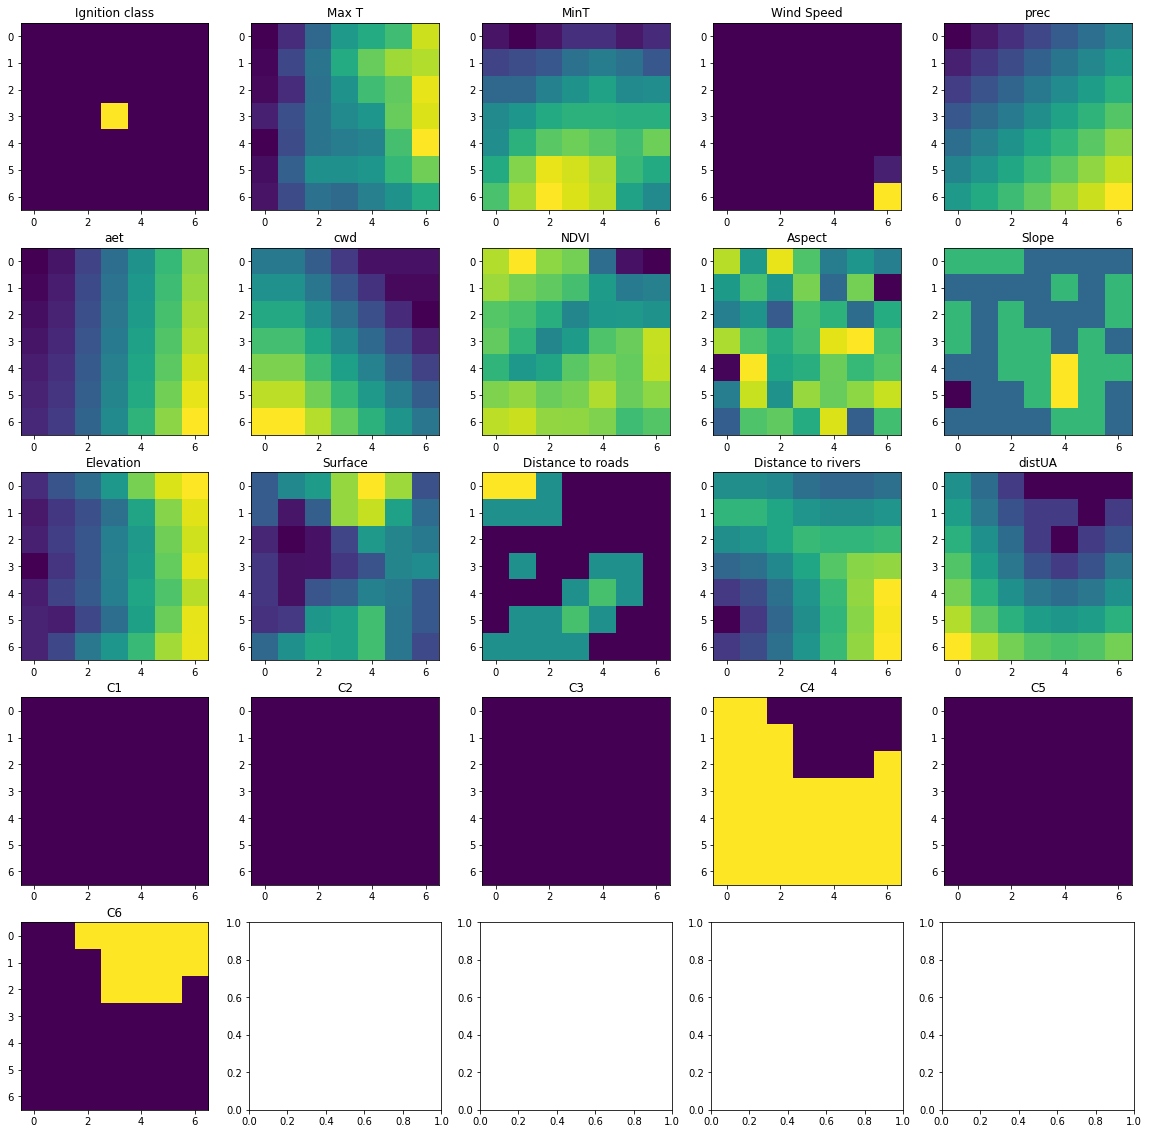

In [ ]:
# centroid = 3
plot_training_example(DataSet, 10)
# DataSet[10,:,:,0],
# DataSet[10,3,3,0] == 1 or DataSet[10,3,3,0] == 0
# Y = np.where(DataSet[:,3,3,0] == 1,1,0) = [1,0,1,0,1,0,1,0,1,0...]

In [ ]:
DataSet3.shape


(9794, 7, 7, 21)

In [ ]:
DataSet3.shape[-1]

21

In [ ]:
centroid = int(patchsize / 2 - 0.5)
Fire = np.where(DataSet3[:,centroid,centroid,0]==1,1,0) 

In [ ]:
#DataSet balanceado
fire = 0
no_fire = 0
for i in Fire:
  if i ==1:
    fire += 1
  else:
    no_fire += 1
print("fire: {}, no fire: {}".format(fire,no_fire))

fire: 4864, no fire: 4930


In [ ]:
def groupby(Y):
  fire = 0
  no_fire = 0
  for i in Y:
    if i ==1:
      fire += 1
    elif i == 0:
      no_fire += 1
    else:
      pass
  print("fire: {}, no fire: {}".format(fire,no_fire))

In [ ]:
m = len(DataSet3)
m

9794

In [ ]:
def diference(Y):
  fire = 0
  no_fire = 0
  for i in Y:
    if i ==1:
      fire += 1
    elif i == 0:
      no_fire += 1
    else:
      pass
  return np.max([fire,no_fire]) -np.min([fire,no_fire])

In [ ]:
diference(Fire)

66

In [ ]:
index = []
j = 0
for i,muestra in enumerate(DataSet3):

  if int(muestra[centroid,centroid,0]) == 0 :
    index.append(i)
    j+=1
  if j == diference(Fire):
    break
  else: 
    pass
 


In [ ]:
len(index)

66

In [ ]:
DataSet4 = np.delete(DataSet3,index,axis = 0)
DataSet4.shape
y = np.where(DataSet4[:,centroid,centroid,0] == 1, 1,0)
X = DataSet4[:,:,:,1::]

In [ ]:
groupby(y)
X.shape

fire: 4864, no fire: 4864


(9728, 7, 7, 20)

# Separación en set de testeo y set de entrenamiento

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
print(X_train.shape, X_test.shape, len(y_train),len(y_test))
groupby(y_train)
groupby(y_test)


(7782, 7, 7, 20) (1946, 7, 7, 20) 7782 1946
fire: 3890, no fire: 3892
fire: 974, no fire: 972


# *5 Fold Cross-validation

In [ ]:
cv = sklearn.model_selection.KFold(5,shuffle = True, random_state = 0)

h = 1
Cross = {}
for train_indices, test_indices in cv.split(X_train):
    x_train_, x_val_ = X_train[train_indices], X_train[test_indices]
    y_train_, y_val_ = y_train[train_indices], y_train[test_indices]
    Cross['Fold_{}'.format(h)] = x_train_, x_val_ ,y_train_, y_val_
    h += 1

X_train_1,X_val_1,y_train_1,y_val_1 = Cross['Fold_1']
X_train_2,X_val_2,y_train_2,y_val_2 = Cross['Fold_2']
X_train_3,X_val_3,y_train_3,y_val_3 = Cross['Fold_3']
X_train_4,X_val_4,y_train_4,y_val_4 = Cross['Fold_4']
X_train_5,X_val_5,y_train_5,y_val_5 = Cross['Fold_5']

In [ ]:
Cross['Fold_1'][0].shape

(6225, 7, 7, 20)

# *Modelo CNN 1

In [ ]:
#Definición de los optimizadores a probar, estos son ADAM Y RMSprop, ya que son lo que usualmente tienen mejores resultados.
lr_schedule_01 = tf.keras.optimizers.schedules.InverseTimeDecay(0.1, decay_steps=1*10, decay_rate=1)
lr_schedule_001 = tf.keras.optimizers.schedules.InverseTimeDecay(0.01, decay_steps=1*10, decay_rate=1)
lr_schedule_0001 = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=1*10, decay_rate=1)
lr_schedule_00001 = tf.keras.optimizers.schedules.InverseTimeDecay(0.0001, decay_steps=1*10, decay_rate=1)
def lr_schedule(l_r):
  return tf.keras.optimizers.schedules.InverseTimeDecay(l_r, decay_steps=1*10, decay_rate=1)
def SGD(lr_schedulee):
  return tf.keras.optimizers.SGD(lr_schedulee)
def Adam1(lr_schedulee = lr_schedule_01):
  return tf.keras.optimizers.Adam(lr_schedulee)

#def RMSprop(lr_schedulee):
#  return tf.keras.optimizers.RMSprop(lr_schedulee)

In [ ]:
from tensorflow import keras
from keras.layers.core import Dropout
from keras.regularizers import L1L2
from keras.layers import BatchNormalization

In [ ]:
#Fold 1 : val accuracy: 0.6511040925979614, train_accuracy: 0.6393752694129944 
# Fold 1 (droppout 0.0) (L1: 0.0) (L2: 0.001) (Learning rate : 0.01) (Optimizer: Adam) (batch_size: 64) (best_epoch: 19)

In [ ]:
XX_train, yy_train,XX_val, yy_val = X_train_1, y_train_1, X_val_1, y_val_1  
model = keras.models.Sequential()
'''
seed_value= 0
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)
'''
#Adam 0.01 0.2 0.0 0.001 64 0.6575434268986731
L1,L2 = 0.0,0.001
do = 0.2
l_r = 0.01
batch = 64
epoch = 20
opt = Adam1(lr_schedulee = lr_schedule(l_r))
# Capas convolucionales
#Conv1


model.add(keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_regularizer=L1L2(L1,L2), input_shape=(patchsize, patchsize, 20)))
model.add(BatchNormalization())
#model.add(Dropout(do))
#Max-pool 1
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2),strides=2))
#model.add(Dropout(do))
#Conv2
model.add(keras.layers.Conv2D(64, kernel_size= (3, 3),activation='relu', kernel_regularizer=L1L2(L1,L2),padding='same'))
#model.add(Dropout(do))
#Max-pool 2
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2),strides=2))
model.add(Dropout(do))
#Conv3
model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu',kernel_regularizer=L1L2(L1,L2),padding = 'same'))
#model.add(Dropout(do))


# Capas fully connected

model.add(keras.layers.Flatten())
#FC1
model.add(keras.layers.Dense(128,kernel_regularizer=L1L2(L1,L2),activation='relu'))
model.add(Dropout(do))
#FC2
model.add(keras.layers.Dense(64, kernel_regularizer=L1L2(L1,L2),activation='relu'))
model.add(Dropout(do))
#FC3
model.add(keras.layers.Dense(32,kernel_regularizer=L1L2(L1,L2),activation='relu'))
model.add(Dropout(do))
#Sigmoid
model.add(keras.layers.Dense(1,kernel_regularizer=L1L2(L1,L2),activation = 'sigmoid'))

#model.summary()

In [ ]:
#with tf.device('cpu:0'): # Esta linea esta solo porque no tengo configurada mi GPU
model.compile(optimizer= opt,
            loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

history = model.fit(XX_train, yy_train, epochs=epoch, batch_size=batch,callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8)],
                    verbose = 0,validation_data=(XX_val, yy_val))

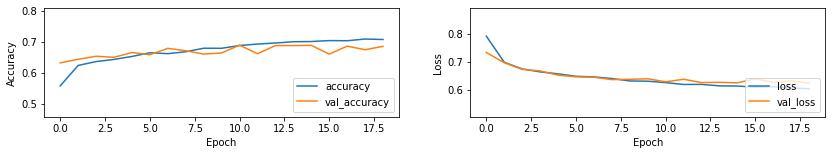

In [ ]:

plot(history = history)

In [ ]:
y_pred = predict(model,XX_val,threshold=0.5)

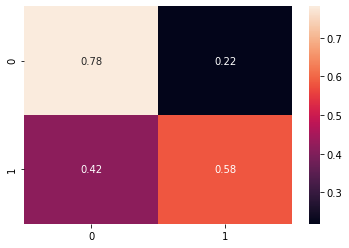

In [ ]:
conf_mat = [0,0]
conf_mat[0] = confusion_matrix(yy_val, y_pred)
conf_mat[1] = conf_mat[0].T / np.sum(conf_mat[0], axis = 1)
# Podemos usar seaborn para graficar esta matriz
sns.heatmap(conf_mat[1].T, annot = True)
plt.show()

In [ ]:
print(f1_score(yy_val, y_pred,average='binary'),recall_score(yy_val,y_pred,average='binary'),precision_score(yy_val,y_pred,average = 'binary'))

0.6423889293517844 0.582562747688243 0.7159090909090909


In [ ]:
a = np.squeeze(model.predict(X_test))

In [ ]:
b = np.array(a)
print(np.max(b),np.min(b),np.std(b))

0.98526263 0.1698493 0.22710845


(array([175., 471., 286., 231., 178., 156., 101.,  74.,  92., 182.]),
 array([0.1698493 , 0.25139064, 0.33293197, 0.4144733 , 0.49601462,
        0.57755595, 0.6590973 , 0.7406386 , 0.82218   , 0.9037213 ,
        0.98526263], dtype=float32),
 <a list of 10 Patch objects>)

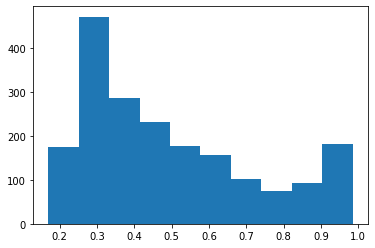

In [ ]:
plt.hist(b)

# *Modelo CNN 2

In [ ]:
#XX_train, yy_train,XX_val, yy_val = X_train_1, y_train_1, X_val_1, y_val_1 
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.core import Dropout, Activation
from keras.regularizers import L1L2
#Adam 0.01 0.0 0.001 0.0 32 0.656386944770528
L1,L2 = 0.001,0.001
do = 0.5
l_r = 0.01
batch = 32
epoch = 20
opt = Adam1(lr_schedulee = lr_schedule(l_r))

model_2 = keras.Sequential()
model_2.add(BatchNormalization())

#Conv1
model_2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(patchsize, patchsize, 20)))
#Max-pool 1
model_2.add(MaxPooling2D(pool_size = (2, 2),strides=2))
#Conv2
model_2.add(Conv2D(64, kernel_size= (3, 3), activation='relu', padding='same'))
#Max-pool 2
model_2.add(MaxPooling2D(pool_size = (2, 2),strides=2))

# Capas fully connected

model_2.add(keras.layers.Flatten())
#FC1
model_2.add(keras.layers.Dense(1024,kernel_regularizer=L1L2(L1,L2), activation='relu'))
model_2.add(Dropout(do))

#Sigmoid
model_2.add(keras.layers.Dense(1, activation = 'sigmoid'))


In [ ]:
model_2.compile(optimizer=opt,
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
history_2 = model_2.fit(XX_train, yy_train, epochs=epoch, batch_size=batch,callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8)],
                    verbose = 0,validation_data=(XX_val, yy_val))

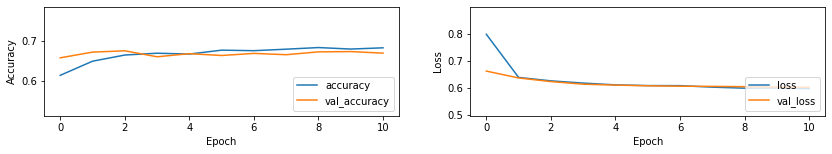

In [ ]:
plot(history = history_2)

In [ ]:
y_pred_2 = predict(model_2,XX_val)

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
import seaborn as sns

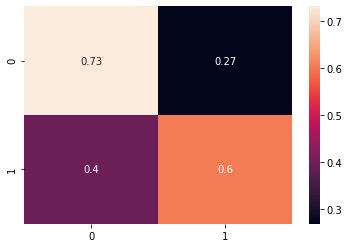

In [ ]:
conf_mat_2 = [0,0]
conf_mat_2[0] = confusion_matrix(yy_val, y_pred_2)
conf_mat_2[1] = conf_mat_2[0].T / np.sum(conf_mat_2[0], axis = 1)
# Podemos usar seaborn para graficar esta matriz
sns.heatmap(conf_mat_2[1].T, annot = True)
plt.show()

In [ ]:
f1_score(yy_val, y_pred_2,average='binary')

0.6396081175647306

In [ ]:
def create_model():
  from keras.layers import Conv2D, MaxPooling2D
  from keras.layers.core import Dropout, Activation
  from keras.regularizers import L1L2
  #Adam 0.01 0.0 0.001 0.0 32 0.656386944770528
  L1,L2 = 0.001,0.001
  do = 0.5
  l_r = 0.01
  batch = 32
  epoch = 20
  opt = Adam1(lr_schedulee = lr_schedule(l_r))

  model_2 = keras.Sequential()
  model_2.add(BatchNormalization())

  #Conv1
  model_2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(patchsize, patchsize, 20)))
  #Max-pool 1
  model_2.add(MaxPooling2D(pool_size = (2, 2),strides=2))
  #Conv2
  model_2.add(Conv2D(64, kernel_size= (3, 3), activation='relu', padding='same'))
  #Max-pool 2
  model_2.add(MaxPooling2D(pool_size = (2, 2),strides=2))

  # Capas fully connected

  model_2.add(keras.layers.Flatten())
  #FC1
  model_2.add(keras.layers.Dense(1024,kernel_regularizer=L1L2(L1,L2), activation='relu'))
  model_2.add(Dropout(do))

  #Sigmoid
  model_2.add(keras.layers.Dense(1, activation = 'sigmoid'))

  model_2.compile(optimizer=opt,
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
  return model_2

# Modelo CNN1 Hypermodel

In [ ]:

# hp es un objeto que representa nuestros hiperparametros,
# que logicamente cambiaran durante el proceso de tuning.
def model_builder(hp):
  '''
  # Seed value
# Apparently you may use different seed values at each stage
  seed_value= 0

  # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
  import os
  os.environ['PYTHONHASHSEED']=str(seed_value)

  # 2. Set `python` built-in pseudo-random generator at a fixed value
  import random
  random.seed(seed_value)

  # 3. Set `numpy` pseudo-random generator at a fixed value
  import numpy as np
  np.random.seed(seed_value)

  # 4. Set `tensorflow` pseudo-random generator at a fixed value
  import tensorflow as tf
  tf.random.set_seed(seed_value)

  # 5. Configure a new global `tensorflow` session
  from keras import backend as K
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  K.set_session(sess)
  '''
  
  #from keras.models import Sequential
  from keras.layers import Conv2D, MaxPooling2D
  from keras.layers.core import Dropout, Activation
  #from keras.optimizers import Adadelta, Adam, RMSprop
  from keras.regularizers import L1L2

  #Opciones de Hiperparámetros
  L_r = hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3, 1e-4])
  #[Adam1(lr_schedulee = L_r_schedule)])
  #Batch_size = [] #pendiente
   #pendiente
  #Batch_size = hp.choice('batch_size', [16,32,64])
  do = hp.Choice('dropout',[0.0,0.2,0.5]) #Dropout_rate 
  L1 = hp.Choice('L1',[0e-1,1e-1,1e-2,1e-3])  #Kernel_regularizers_L1 
  L2 = hp.Choice('L2',[0e-1,1e-1,1e-2,1e-3])  #Kernel_regularizers_L2  
  #Batch_size = hp.Choice('batch_size',[16,32,64])
  Opt = hp.Choice('Optimizer',['Adam'])#,'SGD'])
 
  #hp_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
  #hp_kernel_size = hp.Choice('kernel_size', values=[3, 4, 5])
  #hp_n_conv_layers = hp.Choice('n_conv_layers', values=[3,4,5])
  #hp_conv_activation = hp.Choice('conv_activation', values=['relu', 'elu'])
  
  model = keras.Sequential()
  #Conv1
  
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(patchsize, patchsize, 20)))

  model.add(BatchNormalization())
  #Max-pool 1
  model.add(MaxPooling2D(pool_size = (2, 2),strides=2))

  #Conv2
  model.add(Conv2D(64, kernel_size= (3, 3), activation='relu', padding='same'))

  #Max-pool 2
  model.add(MaxPooling2D(pool_size = (2, 2),strides=2))

  #Conv3
  model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',padding = 'same'))

  # Capas fully connected

  model.add(keras.layers.Flatten())
  #FC1
  model.add(keras.layers.Dense(128,kernel_regularizer=L1L2(L1,L2), activation='relu'))
  model.add(Dropout(do))

  #FC2
  model.add(keras.layers.Dense(64,kernel_regularizer=L1L2(L1,L2), activation='relu'))
  model.add(Dropout(do))

  #FC3
  model.add(keras.layers.Dense(32, kernel_regularizer=L1L2(L1,L2),activation='relu'))
  model.add(Dropout(do))
  
  #Sigmoid
  model.add(keras.layers.Dense(1,kernel_regularizer=L1L2(L1,L2), activation = 'sigmoid'))

  #model.compile(loss='binary_crossentropy', optimizer= Optimizer)

  #model.fit(X_train_2, y_train_2, epochs=params['nb_epochs'], batch_size=params['batch_size'], verbose = 0,callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)],
  #          validation_data=(X_val_2, y_val_2))
  if Opt == 'Adam': #Adam
    Optimizer = Adam1(lr_schedulee = tf.keras.optimizers.schedules.InverseTimeDecay(L_r, decay_steps=1*10, decay_rate=1))
  else: #SGD
    Optimizer = SGD(lr_schedulee = tf.keras.optimizers.schedules.InverseTimeDecay(L_r, decay_steps=1*10, decay_rate=1))
  
  model.compile(optimizer=Optimizer,
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
  return model

# Modelo CNN2 Hypermodel

---



In [ ]:
def model_builder2(hp):
  # Seed value
# Apparently you may use different seed values at each stage
  '''
  seed_value= 0
  
  # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
  import os
  os.environ['PYTHONHASHSEED']=str(seed_value)

  # 2. Set `python` built-in pseudo-random generator at a fixed value
  import random
  random.seed(seed_value)

  # 3. Set `numpy` pseudo-random generator at a fixed value
  import numpy as np
  np.random.seed(seed_value)

  # 4. Set `tensorflow` pseudo-random generator at a fixed value
  import tensorflow as tf
  tf.random.set_seed(seed_value)

  # 5. Configure a new global `tensorflow` session
  from keras import backend as K
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  K.set_session(sess)
  '''
  from keras.layers import Conv2D, MaxPooling2D
  from keras.layers.core import Dropout, Activation
  #from keras.optimizers import Adadelta, Adam, RMSprop
  from keras.regularizers import L1L2

  #Opciones de Hiperparámetros
  L_r = hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3, 1e-4])

  do = hp.Choice('dropout',[0.2,0.5]) #Dropout_rate 
  L1 = hp.Choice('L1',[1e-1,1e-2,1e-3])  #Kernel_regularizers_L1 
  L2 = hp.Choice('L2',[1e-1,1e-2,1e-3])  #Kernel_regularizers_L2
  Opt = hp.Choice('Optimizer',['Adam'])#,'SGD'])  
 
  
  model = keras.Sequential()
  model.add(BatchNormalization())

  #Conv1
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(patchsize, patchsize, 20)))

  #Max-pool 1
  model.add(MaxPooling2D(pool_size = (2, 2),strides=2))

  #Conv2
  model.add(Conv2D(64, kernel_size= (3, 3), activation='relu', padding='same'))

  #Max-pool 2
  model.add(MaxPooling2D(pool_size = (2, 2),strides=2))

  # Capas fully connected

  model.add(keras.layers.Flatten())
  #FC1
  model.add(keras.layers.Dense(1024,kernel_regularizer=L1L2(L1,L2), activation='relu'))
  model.add(Dropout(do))
  
  #Sigmoid
  model.add(keras.layers.Dense(1, activation = 'sigmoid'))



  if Opt == 'Adam': #Adam
    Optimizer = Adam1(lr_schedulee = tf.keras.optimizers.schedules.InverseTimeDecay(L_r, decay_steps=1*10, decay_rate=1))
  else: #SGD
    Optimizer = SGD(lr_schedulee = tf.keras.optimizers.schedules.InverseTimeDecay(L_r, decay_steps=1*10, decay_rate=1))
  
  model.compile(optimizer=Optimizer,
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
  return model

# Optimización de Hiperparámetros CNN1

# Kt.engine.Tuner.tuner, CNN1

In [ ]:
def hyperband():
   return kt.oracles.Hyperband(
    objective=kt.Objective("f1_score", direction="max"),
    max_epochs= 20,
    factor=10,
    hyperband_iterations=1,
    seed=None)  

def bayesian():
   return kt.oracles.BayesianOptimization(
    objective=kt.Objective("f1_score", direction="max"),
    max_trials=20,
    seed = None)

def random():
   return kt.oracles.RandomSearch(
    objective=kt.Objective("f1_score", direction="max"),
    max_trials=10,
    seed=None,
    hyperparameters=None,
    allow_new_entries=True,
    tune_new_entries=True,)

In [ ]:
class CVTuner(kt.engine.tuner.Tuner):

  def run_trial(self, trial, x, y, batch_size=32, epochs=1):
    cv = sklearn.model_selection.KFold(5,shuffle = True, random_state = 0)
    f1_scores = []
    h = 0
    for train_indices, test_indices in cv.split(x):
        x_train, x_test = x[train_indices], x[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        model = self.hypermodel.build(trial.hyperparameters)

        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 0)
        y_pred = model.predict(x_test)
        K.clear_session()
        y_pred = np.where(y_pred >= 0.5,1,0)
        #val_losses.append(model.evaluate(x_test, y_test))
        f1 = f1_score(y_test,y_pred,average = 'binary')
        f1_scores.append(f1)
        print("FOLD: {}, : f1_score: {}".format(h+1,f1))
        h+=1

    self.oracle.update_trial(trial.trial_id, {'f1_score': np.mean(f1_scores)})
    self.save_model(trial.trial_id, model)
best_CNN = []

#with tf.device('cpu:0'):
for batch in [16,32,64]:
  cnn1_tuner = CVTuner(
  hypermodel=model_builder,
  oracle=hyperband(),
    directory='CNN1_FINAL_{}'.format(batch+3),
    project_name = '1'
    )
  cnn1_tuner.search(X_train, y_train, batch_size=batch, epochs=5)
  best_CNN.append(cnn1_tuner.get_best_hyperparameters(num_trials=1))


Trial 23 Complete [00h 00m 33s]
f1_score: 0.5322211648534296

Best f1_score So Far: 0.602219215558695
Total elapsed time: 00h 13m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hpsss = []
BATCH = [16,32,64]
for i,hyperparameters in enumerate(best_CNN):
  folds_top3 = []
  for train_indices, test_indices in cv.split(X_train):
      x_train__, x_val__ = X_train[train_indices], X_train[test_indices]
      y_train__, y_val__ = y_train[train_indices], y_train[test_indices]

      model_top3 = cnn1_tuner.hypermodel.build(hyperparameters[0])
      history_top3 = model_top3.fit(x_train__, y_train__, validation_data = (x_val__,y_val__),epochs=50,callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)],batch_size=BATCH[i], verbose = 0)

      y_pred = predict(model_top3,x_val__)
      K.clear_session()
      f1 = f1_score(y_val__,y_pred,average='binary')
      folds_top3.append(f1)
  mean = np.mean(folds_top3)
  best_hpsss.append((hyperparameters,mean,BATCH[i]))


best_hpss = sorted(best_hpsss,reverse=True, key=lambda best_hpsss: best_hpsss[1])

In [ ]:
#CROSSVALIDATION PARA LOS 3 BATCHSIZES
for i in range(3):
  print(best_hpss[i][0][0].get('Optimizer'),
        best_hpss[i][0][0].get('learning_rate'),
        best_hpss[i][0][0].get('dropout'),
        best_hpss[i][0][0].get('L1'),
        best_hpss[i][0][0].get('L2'),
        best_hpss[i][2],
        best_hpss[i][1]

  )

Adam 0.001 0.5 0.001 0.01 32 0.6108897802990384
Adam 0.0001 0.0 0.01 0.001 64 0.5402575145089843
Adam 0.01 0.5 0.1 0.001 16 0.39785937042093


In [ ]:
best_batch = best_hpss[0][2]
Final_f1scores_cnn1 = []
Model_CNN1_save = []
ACC = []
VAL_ACC = []
cv = sklearn.model_selection.KFold(5,shuffle = True, random_state = 0)
for i in range(0,3): #Encontrar la mejor semilla aleatoria del modelo escogido, considerando los 5 folds del CV, para guardarla y calcular f1_score
  

  for train_indices, test_indices in cv.split(X_train):
      x_train__, x_val__ = X_train[train_indices], X_train[test_indices]
      y_train__, y_val__ = y_train[train_indices], y_train[test_indices]
      cnn1_model = cnn1_tuner.hypermodel.build(best_hpss[0][0][0])
      history = cnn1_model.fit(x_train__, y_train__, validation_data = (x_val__,y_val__),epochs=50,callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)],batch_size=best_batch, verbose = 0)
      Accuracy = history.history['accuracy'][-1]
      val_Accuracy = history.history['val_accuracy'][-1]
      y_pred = predict(cnn1_model,x_val__)
      K.clear_session()
      #Final_f1scores_cnn1.append(f1_score(y_val__,y_pred,average='micro'))
      f1 = f1_score(y_val__,y_pred,average='binary')
      #print(f1)
      Model_CNN1_save.append((f1,Accuracy,val_Accuracy, history,cnn1_model,x_val__,y_val__))

      ACC.append(Accuracy)
      VAL_ACC.append(val_Accuracy)
      Final_f1scores_cnn1.append(f1)
  
 

F1 = np.array(Final_f1scores_cnn1)
ACC = np.array(ACC)
VAL_ACC = np.array(VAL_ACC)


mean_train_CNN1 = np.mean(ACC)
std_train_CNN1 = np.std(ACC)
mean_val_CNN1 = np.mean(VAL_ACC)
std_val_CNN1 = np.std(VAL_ACC)
mean_f1_CNN1 = np.mean(F1)
std_f1_CNN1 = np.std(F1)


print(mean_train_CNN1,std_train_CNN1,mean_val_CNN1,std_val_CNN1)
print(mean_f1_CNN1,std_f1_CNN1)

Model_CNN1_save_sorted = sorted(Model_CNN1_save,reverse=True, key=lambda Model_CNN1_save: Model_CNN1_save[0])
Best_model_CNN1_save = Model_CNN1_save_sorted[0]

0.5526320815086365 0.01913487416126432 0.590508743127187 0.012005660902408425
0.6110912046898211 0.03903143608968281


In [ ]:
print(Model_CNN1_save_sorted[0][0])
print(Model_CNN1_save_sorted[0][1])
print(Model_CNN1_save_sorted[0][2])
print(Model_CNN1_save_sorted[0][3])
print(Model_CNN1_save_sorted[0][4])
print(Model_CNN1_save_sorted[0][5].shape)
print(Model_CNN1_save_sorted[0][6].shape)

#Model_CNN1_save_sorted = sorted(Model_CNN1_save,reverse=True, key=lambda Model_CNN1_save: Model_CNN1_save[0])
#Best_model_CNN1_save = Model_CNN1_save_sorted[0]

0.6691449814126393
0.5465788841247559
0.5996143817901611
(1556, 7, 7, 20)
(1556,)


Modelo escogido con el que se obtuvo mejores resultados

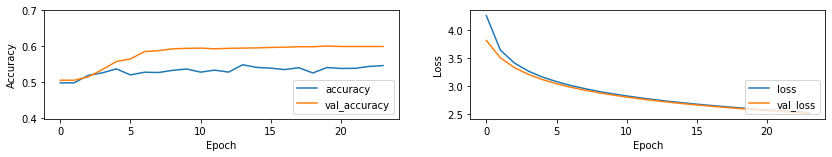

In [ ]:

cnn1_model = Model_CNN1_save_sorted[0][4]
history = Model_CNN1_save_sorted[0][3]
y_pred =predict(cnn1_model,Model_CNN1_save_sorted[0][5])
K.clear_session()
plot(history = history)


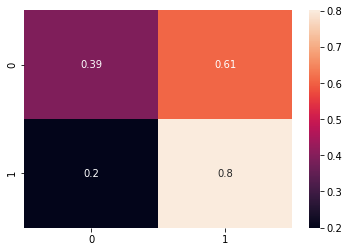

In [ ]:
conf_mat = [0,0]
conf_mat[0] = confusion_matrix(Model_CNN1_save_sorted[0][6], y_pred)
conf_mat[1] = conf_mat[0].T / np.sum(conf_mat[0], axis = 1)
# Podemos usar seaborn para graficar esta matriz
sns.heatmap(conf_mat[1].T, annot = True)
plt.show()

In [ ]:
#Mejor F1 score obtenido corriendo n veces crossvalidation, con el modelo escogido
f1_score(Model_CNN1_save_sorted[0][6],y_pred,average = 'binary')

0.6691449814126393

# f1 score y matriz de confusión CNN1 (TEST)

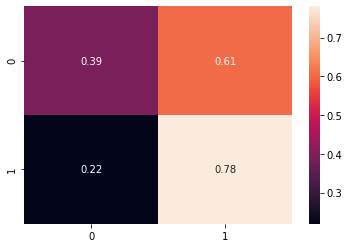

In [ ]:
y_pred = predict(cnn1_model,X_test,threshold=0.5)
conf_mat = [0,0]
conf_mat[0] = confusion_matrix(y_test, y_pred)
conf_mat[1] = conf_mat[0].T / np.sum(conf_mat[0], axis = 1)
# Podemos usar seaborn para graficar esta matriz
sns.heatmap(conf_mat[1].T, annot = True)
plt.show()

In [ ]:
print(f1_score(y_test, y_pred,average='binary'),recall_score(y_test,y_pred,average='binary'),precision_score(y_test,y_pred,average = 'binary'))

0.6540447504302926 0.7802874743326489 0.562962962962963


(array([709., 470., 370., 105.,  65.,  68.,  64.,  34.,  48.,  13.]),
 array([0.49462146, 0.50302505, 0.5114286 , 0.5198322 , 0.52823573,
        0.53663933, 0.54504293, 0.5534465 , 0.5618501 , 0.5702536 ,
        0.5786572 ], dtype=float32),
 <a list of 10 Patch objects>)

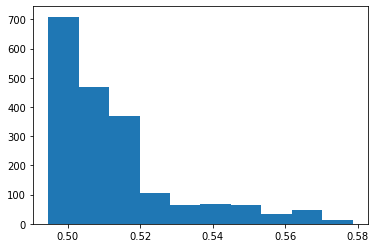

In [ ]:
a = np.squeeze(cnn1_model.predict(X_test))
b = np.array(a)
plt.hist(b)

# Rangos susceptibilidad CNN1

In [ ]:
#Mapeo de susceptibilidad EN BASE A FP Y FN
Mapeo = {}
for i in range(48,60,1):
  i = round(i/100,4)
  threshold = round(i,4)
  y_pred = predict(cnn1_model,X_test,threshold= threshold)
  conf_mat = [0,0]
  conf_mat[0] = confusion_matrix(y_test, y_pred)
  conf_mat[1] = conf_mat[0].T / np.sum(conf_mat[0], axis = 1)
  Mapeo['{}'.format(round(threshold,3))] = (round(conf_mat[1][0][1],2), round(conf_mat[1][1][0],2),round(f1_score(y_test,y_pred,average='binary'),3))
print('     FN   FP  f1_score')
for i in Mapeo:
  print('{}:{}'.format(i,Mapeo[i]))

     FN   FP  f1_score
0.48:(0.0, 1.0, 0.667)
0.49:(0.0, 1.0, 0.667)
0.5:(0.22, 0.61, 0.654)
0.51:(0.49, 0.35, 0.552)
0.52:(0.7, 0.11, 0.423)
0.53:(0.78, 0.06, 0.342)
0.54:(0.84, 0.05, 0.262)
0.55:(0.92, 0.03, 0.145)
0.56:(0.95, 0.02, 0.086)
0.57:(0.99, 0.01, 0.016)
0.58:(1.0, 0.0, 0.0)
0.59:(1.0, 0.0, 0.0)


# Optimización de Hiperparámetros CNN2 

# Kt.engine.Tuner.tuner, CNN2

In [ ]:
def hyperband():
   return kt.oracles.Hyperband(
    objective=kt.Objective("f1_score", direction="max"),
    max_epochs= 20,
    factor=1,
    hyperband_iterations=1,
    seed=None)  

def bayesian():
   return kt.oracles.BayesianOptimization(
    objective=kt.Objective("f1_score", direction="max"),
    max_trials=20,
    seed = None)

def random():
   return kt.oracles.RandomSearch(
    objective=kt.Objective("f1_score", direction="max"),
    max_trials=10,
    seed=None,
    hyperparameters=None,
    allow_new_entries=True,
    tune_new_entries=True,)

In [ ]:
class CVTuner(kt.engine.tuner.Tuner):

  def run_trial(self, trial, x, y, batch_size=32, epochs=1):
    cv = sklearn.model_selection.KFold(5,shuffle = True, random_state = 0)
    f1_scores = []
    h = 0
    for train_indices, test_indices in cv.split(x):
        x_train, x_test = x[train_indices], x[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        model = self.hypermodel.build(trial.hyperparameters)

        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 0)
        y_pred = model.predict(x_test)
        K.clear_session()
        y_pred = np.where(y_pred >= 0.5,1,0)
        #val_losses.append(model.evaluate(x_test, y_test))
        f1 = f1_score(y_test,y_pred,average = 'binary')
        f1_scores.append(f1)
        print("FOLD: {}, : f1_score: {}".format(h+1,f1))
        h+=1

    self.oracle.update_trial(trial.trial_id, {'f1_score': np.mean(f1_scores)})
    self.save_model(trial.trial_id, model)


best_CNN2 = []
#with tf.device('cpu:0'):
for batch in [16,32,64]:
  cnn2_tuner = CVTuner(
  hypermodel=model_builder2,
  oracle=bayesian(),
    directory='CNN2_FINAL_{}'.format(batch),
    project_name='1'
    )
  cnn2_tuner.search(X_train, y_train, batch_size=batch, epochs=5)
  best_CNN2.append(cnn2_tuner.get_best_hyperparameters(num_trials=1))

Trial 20 Complete [00h 00m 29s]
f1_score: 0.5344136282398368

Best f1_score So Far: 0.6065715103766534
Total elapsed time: 00h 09m 49s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hpsss = []
BATCH = [16,32,64]
for i,hyperparameters in enumerate(best_CNN2):
  folds_top3 = []
  for train_indices, test_indices in cv.split(X_train):
      x_train__, x_val__ = X_train[train_indices], X_train[test_indices]
      y_train__, y_val__ = y_train[train_indices], y_train[test_indices]

      model_top3 = cnn2_tuner.hypermodel.build(hyperparameters[0])
      history_top3 = model_top3.fit(x_train__, y_train__, validation_data = (x_val__,y_val__),epochs=50,callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)],batch_size=BATCH[i], verbose = 0)

      y_pred = predict(model_top3,x_val__)
      K.clear_session()
      f1 = f1_score(y_val__,y_pred,average='binary')
      folds_top3.append(f1)
  mean = np.mean(folds_top3)
  best_hpsss.append((hyperparameters,mean,BATCH[i]))


best_hpss2 = sorted(best_hpsss,reverse=True, key=lambda best_hpsss: best_hpsss[1])

In [ ]:
#CROSSVALIDATION PARA LOS 3 BATCHSIZES
for i in range(3):
  print(best_hpss2[i][0][0].get('Optimizer'),
        best_hpss2[i][0][0].get('learning_rate'),
        best_hpss2[i][0][0].get('dropout'),
        best_hpss2[i][0][0].get('L1'),
        best_hpss2[i][0][0].get('L2'),
        best_hpss2[i][2],
        best_hpss2[i][1]

  )

Adam 0.01 0.5 0.001 0.001 32 0.6415642719336343
Adam 0.01 0.2 0.001 0.001 16 0.6186086093010514
Adam 0.0001 0.5 0.1 0.1 64 0.6010088435407009


In [ ]:
best_batch2 = best_hpss2[0][2]
Final_f1scores_cnn2 = []
Model_CNN2_save = []
ACC = []
VAL_ACC = []
Final_f1scores_cnn2 = []
cv = sklearn.model_selection.KFold(5,shuffle = True, random_state = 0)
for i in range(0,3):
  folds = []
  for train_indices, test_indices in cv.split(X_train):
      x_train__, x_val__ = X_train[train_indices], X_train[test_indices]
      y_train__, y_val__ = y_train[train_indices], y_train[test_indices]
      cnn2_model = cnn2_tuner.hypermodel.build(best_hpss2[0][0][0])
      history = cnn2_model.fit(x_train__, y_train__, validation_data = (x_val__,y_val__),epochs=50,batch_size=best_batch2,callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)], verbose = 0)
      Accuracy = history.history['accuracy'][-1]
      val_Accuracy = history.history['val_accuracy'][-1]
      y_pred = predict(cnn2_model,x_val__)
      K.clear_session()
      #Final_f1scores_cnn1.append(f1_score(y_val__,y_pred,average='micro'))
      f1 = f1_score(y_val__,y_pred,average='binary')
      Model_CNN2_save.append((f1,Accuracy,val_Accuracy, history,cnn2_model,x_val__,y_val__))
      
      ACC.append(Accuracy)
      VAL_ACC.append(val_Accuracy)
      Final_f1scores_cnn2.append(f1)
  
 

F1 = np.array(Final_f1scores_cnn2)
ACC = np.array(ACC)
VAL_ACC = np.array(VAL_ACC)


mean_train_CNN2 = np.mean(ACC)
std_train_CNN2 = np.std(ACC)
mean_val_CNN2 = np.mean(VAL_ACC)
std_val_CNN2 = np.std(VAL_ACC)
mean_f1_CNN2 = np.mean(F1)
std_f1_CNN2 = np.std(F1)


print(mean_train_CNN2,std_train_CNN2,mean_val_CNN2,std_val_CNN2)
print(mean_f1_CNN2,std_f1_CNN2)   

Model_CNN2_save_sorted = sorted(Model_CNN2_save,reverse=True, key=lambda Model_CNN2_save: Model_CNN2_save[0])
Best_mode2_CNN2_save = Model_CNN2_save_sorted[0]

0.6832647323608398 0.005724390955627348 0.6651270190874735 0.01230415580763949
0.6469922911390656 0.015786127413053793


In [ ]:
print(Model_CNN2_save_sorted[0][0])
print(Model_CNN2_save_sorted[0][1])
print(Model_CNN2_save_sorted[0][2])
print(Model_CNN2_save_sorted[0][3])
print(Model_CNN2_save_sorted[0][4])
print(Model_CNN2_save_sorted[0][5].shape)
print(Model_CNN2_save_sorted[0][6].shape)


0.6782145236508994
0.681175708770752
0.6895886659622192
(1556, 7, 7, 20)
(1556,)


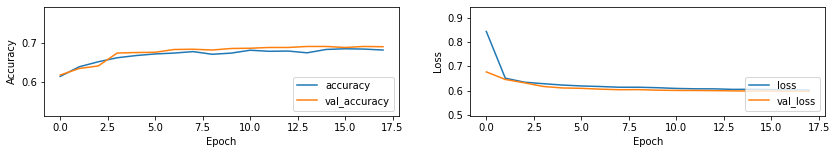

In [ ]:
cnn2_model = Model_CNN2_save_sorted[0][4]
history = Model_CNN2_save_sorted[0][3]
y_pred_2 =predict(cnn2_model,Model_CNN2_save_sorted[0][5])
K.clear_session()
plot(history = history)

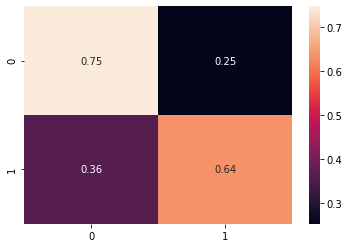

In [ ]:

conf_mat = [0,0]
conf_mat[0] = confusion_matrix(Model_CNN2_save_sorted[0][6], y_pred_2)
conf_mat[1] = conf_mat[0].T / np.sum(conf_mat[0], axis = 1)
# Podemos usar seaborn para graficar esta matriz
sns.heatmap(conf_mat[1].T, annot = True)
plt.show()

In [ ]:
#Mejor F1 score obtenido corriendo n veces crossvalidation, con el modelo escogido
f1_score(Model_CNN2_save_sorted[0][6],y_pred_2,average = 'binary')

0.6782145236508994

# f1 score y matriz de confusión CNN2 (TEST)

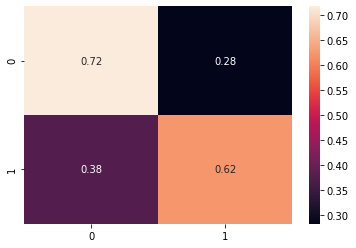

In [ ]:
y_pred_2 = predict(cnn2_model,X_test,threshold=0.5)
conf_mat = [0,0]
conf_mat[0] = confusion_matrix(y_test, y_pred_2)
conf_mat[1] = conf_mat[0].T / np.sum(conf_mat[0], axis = 1)
# Podemos usar seaborn para graficar esta matriz
sns.heatmap(conf_mat[1].T, annot = True)
plt.show()

In [ ]:
print(f1_score(y_test, y_pred_2,average='binary'),recall_score(y_test,y_pred_2,average='binary'),precision_score(y_test,y_pred_2,average = 'binary'))

0.6551724137931035 0.6242299794661191 0.6893424036281179


(array([121., 244., 345., 268., 249., 244., 126.,  96., 123., 130.]),
 array([0.1409497 , 0.22308816, 0.30522662, 0.38736507, 0.46950352,
        0.551642  , 0.6337804 , 0.7159189 , 0.7980574 , 0.8801958 ,
        0.9623343 ], dtype=float32),
 <a list of 10 Patch objects>)

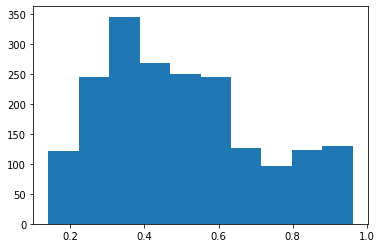

In [ ]:
a = np.squeeze(cnn2_model.predict(X_test))
b = np.array(a)
plt.hist(b)

In [ ]:
cnn2_model.save_weights('/content/drive/MyDrive/Certamen/Modelo_CNN2_save/CNN2',save_format='tf')#,save_format = 'tf')
cnn1_model.save_weights('/content/drive/MyDrive/Certamen/Modelo_CNN1_save/CNN1',save_format='tf')#,save_format = 'tf')

In [ ]:
#model_7 = create_model()
#model_7.load_weights('/content/drive/MyDrive/Certamen/Modelo_CNN2_save/CNN2')

# Rangos susceptibilidad CNN2

In [ ]:
#Mapeo de susceptibilidad EN BASE A FP Y FN
Mapeo = {}
for i in range(1,10):
  threshold = round(i * 0.1,5)
  y_pred_2 = predict(cnn2_model,X_test,threshold= threshold)
  conf_mat = [0,0]
  conf_mat[0] = confusion_matrix(y_test, y_pred_2)
  conf_mat[1] = conf_mat[0].T / np.sum(conf_mat[0], axis = 1)
  Mapeo['{}'.format(round(threshold,3))] = (round(conf_mat[1][0][1],2), round(conf_mat[1][1][0],2),round(f1_score(y_test,y_pred_2,average="binary"),2))

print('         FN   FP  f1_score')
Mapeo

         FN   FP  f1_score


{'0.1': (0.0, 1.0, 0.67),
 '0.2': (0.01, 0.95, 0.67),
 '0.3': (0.08, 0.73, 0.7),
 '0.4': (0.24, 0.45, 0.69),
 '0.5': (0.38, 0.28, 0.66),
 '0.6': (0.56, 0.13, 0.56),
 '0.7': (0.7, 0.08, 0.44),
 '0.8': (0.78, 0.03, 0.36),
 '0.9': (0.91, 0.0, 0.17)}

# Generación del dataset MLP

# Separación en set de testeo y set de entrenamiento

Recorte en el centroide de los datos originales de testeo

In [ ]:
X_test_2 = X_test[:,centroid,centroid,:]
X_train_2 = X_test[:,centroid,centroid,:]

In [ ]:
groupby(y_train)
groupby(y_test)
print(X_train_2.shape,X_test_2.shape)

fire: 3890, no fire: 3892
fire: 974, no fire: 972
(1946, 20) (1946, 20)


# *5 Fold Cross-validation

In [ ]:
cv = sklearn.model_selection.KFold(5,shuffle = True, random_state = 0)

h = 1
Cross_2 = {}
for train_indices, test_indices in cv.split(X_train_2):
    x_train_, x_val_ = X_train_2[train_indices], X_train_2[test_indices]
    y_train_, y_val_ = y_train[train_indices], y_train[test_indices]
    Cross_2['Fold_{}'.format(h)] = x_train_, x_val_ ,y_train_, y_val_
    h += 1

X_train_2_1,X_val_2_1,y_train_2_1,y_val_2_1 = Cross_2['Fold_1']
X_train_2_2,X_val_2_2,y_train_2_2,y_val_2_2 = Cross_2['Fold_2']
X_train_2_3,X_val_2_3,y_train_2_3,y_val_2_3 = Cross_2['Fold_3']
X_train_2_4,X_val_2_4,y_train_2_4,y_val_2_4 = Cross_2['Fold_4']
X_train_2_5,X_val_2_5,y_train_2_5,y_val_2_5 = Cross_2['Fold_5']

# *Modelo MLP

In [ ]:
XX_train, yy_train,XX_val, yy_val = X_train_2_1, y_train_2_1, X_val_2_1, y_val_2_1  
MLP_model = keras.models.Sequential()
L1,L2 = 0,0
do = 0
l_r = 0.001
batch = 64
epoch = 100
opt = Adam1(lr_schedulee = lr_schedule(l_r))

  
# Capas fully connected
MLP_model.add(keras.layers.InputLayer(input_shape=(X_train_2.shape[1],)))
#MLP_model.add(BatchNormalization())
#FC1
MLP_model.add(keras.layers.Dense(64,kernel_regularizer=L1L2(L1,L2),activation='relu'))
MLP_model.add(Dropout(do))
#FC2
MLP_model.add(keras.layers.Dense(64, kernel_regularizer=L1L2(L1,L2),activation='relu'))
MLP_model.add(Dropout(do))

MLP_model.add(keras.layers.Dense(64, kernel_regularizer=L1L2(L1,L2),activation='relu'))
MLP_model.add(Dropout(do))

#Sigmoid
MLP_model.add(keras.layers.Dense(1,activation = 'sigmoid'))

#MLP_model.summary()

In [ ]:
#path = '/content/drive/MyDrive/Ayudantia 2/figs/LRtf.png'
# Exportamos un diagrama
#tf.keras.utils.plot_model(MLP_model, path, show_shapes=True)

In [ ]:
#with tf.device('cpu:0'): # Esta linea esta solo porque no tengo configurada mi GPU
MLP_model.compile(optimizer=opt,
            loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

history_3 = MLP_model.fit(XX_train, yy_train, epochs=epoch, batch_size=batch,
                    verbose = 0,validation_data=(XX_val, yy_val),callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8)])
#callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)]

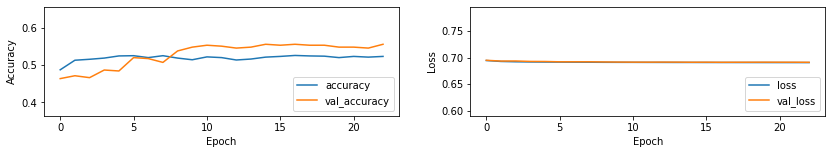

In [ ]:
plot(history = history_3)

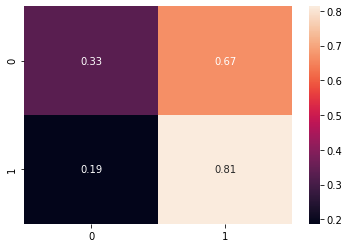

In [ ]:
y_pred_3 = predict(MLP_model,XX_val)
conf_mat_2 = [0,0]
conf_mat_2[0] = confusion_matrix(yy_val, y_pred_3)
conf_mat_2[1] = conf_mat_2[0].T / np.sum(conf_mat_2[0], axis = 1)
# Podemos usar seaborn para graficar esta matriz
sns.heatmap(conf_mat_2[1].T, annot = True)
plt.show()

In [ ]:
f1_score(yy_val, y_pred_3,average='binary')

0.6311300639658849

(array([145., 438., 477., 546., 210.,  51.,  14.,  14.,  27.,  24.]),
 array([0.49443504, 0.5006415 , 0.506848  , 0.51305443, 0.5192609 ,
        0.52546734, 0.5316738 , 0.53788024, 0.5440867 , 0.55029315,
        0.5564996 ], dtype=float32),
 <a list of 10 Patch objects>)

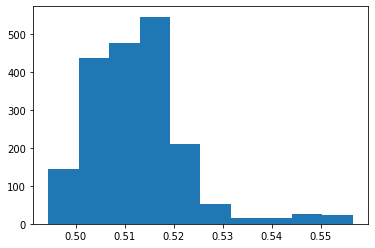

In [ ]:
plt.hist(np.array(MLP_model.predict(X_test_2)))

# Modelo MLP Hypermodel

In [ ]:
def model_builder4(hp):

  MLP_model = keras.models.Sequential()


  #Opciones de Hiperparámetros
  L_r = hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3, 1e-4])

  #do = hp.Choice('dropout',[0.0,0.2,0.5]) #Dropout_rate 
  #L1 = hp.Choice('L1',[0e-1,1e-1,1e-2,1e-3])  #Kernel_regularizers_L1 
  #L2 = hp.Choice('L2',[0e-1,1e-1,1e-2,1e-3])  #Kernel_regularizers_L2
  Opt = hp.Choice('Optimizer',['Adam','SGD'])  

    
  # Capas fully connected
  MLP_model.add(keras.layers.InputLayer(input_shape=(X_train_2.shape[1],)))
  #MLP_model.add(BatchNormalization())
  #FC1
  MLP_model.add(keras.layers.Dense(64,activation='relu'))
  #MLP_model.add(Dropout(do))
  #FC2
  MLP_model.add(keras.layers.Dense(64,activation='relu'))
  #MLP_model.add(Dropout(do))
  #FC3
  MLP_model.add(keras.layers.Dense(64,activation='relu'))
  #MLP_model.add(Dropout(do))
  
  #Sigmoid
  MLP_model.add(keras.layers.Dense(1,activation = 'sigmoid'))
  
  if Opt == 'Adam': #Adam
    Optimizer = Adam1(lr_schedulee = lr_schedule(L_r))
  else: #SGD
    Optimizer = SGD(lr_schedulee = lr_schedule(L_r))

  MLP_model.compile(optimizer= Optimizer,
            loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

  return MLP_model

# Modelo MLP Hypermodel, propuesta

In [ ]:
def model_builder5(hp):

  MLP_model = keras.models.Sequential()
  '''
  Trial 139 Complete [00h 00m 09s]
  f1_score: 0.3568817512699678

  Best f1_score So Far: 0.6624144025745778
  Total elapsed time: 00h 25m 06s

  Search: Running Trial #140

  Hyperparameter    |Value             |Best Value So Far 
  learning_rate     |0.0001            |0.1               
  dropout           |0.2               |0.2               
  L1                |0.001             |0.1               
  L2                |0                 |0.01              
  Optimizer         |SGD               |Adam              
  Layers            |5                 |5                 
  Neuronas          |120               |120               
  tuner/epochs      |20                |3                 
  tuner/initial_e...|0                 |2                 
  tuner/bracket     |0                 |4                 
  tuner/round       |0                 |1                 
  '''

  #Opciones de Hiperparámetros
  L_r = hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3,1e-4])

  do = hp.Choice('dropout',[0.0,0.2,0.5]) #Dropout_rate 
  L1 = hp.Choice('L1',[0e-1,1e-1,1e-2,1e-3])  #Kernel_regularizers_L1 
  L2 = hp.Choice('L2',[0e-1,1e-1,1e-2,1e-3])  #Kernel_regularizers_L2
  Opt = hp.Choice('Optimizer',['Adam','SGD'])  
  layers = hp.Choice('Layers',[5,6])
  Neuronas = hp.Choice('Neuronas',[32,64,120])
    
  # Capas fully connected
  MLP_model.add(keras.layers.InputLayer(input_shape=(X_train_2.shape[1],)))
  MLP_model.add(BatchNormalization())

  #FC1
  for i in range(layers):
    MLP_model.add(keras.layers.Dense(Neuronas,activation='relu'))
    MLP_model.add(Dropout(do))
  
  #Sigmoid
  MLP_model.add(keras.layers.Dense(1,activation = 'sigmoid'))
  
  if Opt == 'Adam': #Adam
    Optimizer = Adam1(lr_schedulee = lr_schedule(L_r))
  else: #SGD
    Optimizer = SGD(lr_schedulee = lr_schedule(L_r))
  

  MLP_model.compile(optimizer= Optimizer,
            loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

  return MLP_model

# Optimización de Hiperparámetros MLP

# Kt.engine.Tuner.tuner, MLP

In [ ]:
def hyperband():
   return kt.oracles.Hyperband(
    objective=kt.Objective("f1_score", direction="max"),
    max_epochs= 20,
    factor=2,
    hyperband_iterations=1,
    seed=None)  

def bayesian():
   return kt.oracles.BayesianOptimization(
    objective=kt.Objective("f1_score", direction="max"),
    max_trials=20,
    seed = None)

def random():
   return kt.oracles.RandomSearch(
    objective=kt.Objective("f1_score", direction="max"),
    max_trials=10,
    seed=None,
    hyperparameters=None,
    allow_new_entries=True,
    tune_new_entries=True,)

In [ ]:
class CVTuner2(kt.engine.tuner.Tuner):

  def run_trial(self, trial, x, y, batch_size=32, epochs=1):
    cv = sklearn.model_selection.KFold(5,shuffle = True, random_state = 0)
    f1_scores = []
    h = 0
    for train_indices, test_indices in cv.split(x):
        x_train, x_test = x[train_indices], x[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        model = self.hypermodel.build(trial.hyperparameters)

        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 0)
        y_pred = model.predict(x_test)
        K.clear_session()
        y_pred = np.where(y_pred >= 0.5,1,0)
        #val_losses.append(model.evaluate(x_test, y_test))
        f1 = f1_score(y_test,y_pred,average = 'binary')
        f1_scores.append(f1)
        print("FOLD: {}, : f1_score: {}".format(h+1,f1))
        h+=1

    self.oracle.update_trial(trial.trial_id, {'f1_score': np.mean(f1_scores)})
    self.save_model(trial.trial_id, model)

best_MLP = []
#with tf.device('cpu:0'):
for batch in [16,32,64]:
  MLP_tuner = CVTuner2(
  hypermodel=model_builder4,
  oracle=hyperband(),
    directory='MLP_FINAL_{}'.format(batch+1),
    project_name='1'
    )
  MLP_tuner.search(X_train_2, y_train, batch_size=batch, epochs=5)
  best_MLP.append(MLP_tuner.get_best_hyperparameters(num_trials=1))

Trial 8 Complete [00h 00m 05s]
f1_score: 0.4415620048713557

Best f1_score So Far: 0.5498416033283859
Total elapsed time: 00h 00m 47s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hpsss = []
BATCH = [16,32,64]
for i,hyperparameters in enumerate(best_MLP):
  folds_top3 = []
  for train_indices, test_indices in cv.split(X_train_2):
      x_train__, x_val__ = X_train_2[train_indices], X_train_2[test_indices]
      y_train__, y_val__ = y_train[train_indices], y_train[test_indices]

      model_top3 = MLP_tuner.hypermodel.build(hyperparameters[0])
      history_top3 = model_top3.fit(x_train__, y_train__, validation_data = (x_val__,y_val__),epochs=50,callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)],batch_size=BATCH[i], verbose = 0)

      y_pred = predict(model_top3,x_val__)
      K.clear_session()
      f1 = f1_score(y_val__,y_pred,average='binary')
      folds_top3.append(f1)
  mean = np.mean(folds_top3)
  best_hpsss.append((hyperparameters,mean,BATCH[i]))


best_hpss3 = sorted(best_hpsss,reverse=True, key=lambda best_hpsss: best_hpsss[1])

In [ ]:
#CROSSVALIDATION PARA LOS 3 BATCHSIZES
for i in range(3):
  print(best_hpss3[i][0][0].get('Optimizer'),
        best_hpss3[i][0][0].get('learning_rate'),
        #best_hpss3[i][0][0].get('dropout'),
        #best_hpss3[i][0][0].get('L1'),
        #best_hpss3[i][0][0].get('L2'),
        best_hpss3[i][2],
        best_hpss3[i][1]

  )

Adam 0.01 16 0.5552404641776031
Adam 0.01 64 0.5546099154851701
Adam 0.0001 32 0.46621857485260376


In [ ]:
best_batch3 = best_hpss3[0][2]
Final_f1scores_MLP = []
Model_MLP_save = []
ACC = []
VAL_ACC = []


cv = sklearn.model_selection.KFold(5,shuffle = True, random_state = 0)
for i in range(0,3):

  for train_indices, test_indices in cv.split(X_train_2):
      x_train__, x_val__ = X_train_2[train_indices], X_train_2[test_indices]
      y_train__, y_val__ = y_train[train_indices], y_train[test_indices]
      MLP_model = MLP_tuner.hypermodel.build(best_hpss3[0][0][0])
      history = MLP_model.fit(x_train__, y_train__, validation_data = (x_val__,y_val__),epochs=50,batch_size=best_batch3,callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)], verbose = 0)
      Accuracy = history.history['accuracy'][-1]
      val_Accuracy = history.history['val_accuracy'][-1]
      y_pred = predict(MLP_model,x_val__)
      K.clear_session()
      f1 = f1_score(y_val__,y_pred,average='binary')
      Model_MLP_save.append((f1,Accuracy,val_Accuracy, history,MLP_model,x_val__,y_val__))

      ACC.append(Accuracy)
      VAL_ACC.append(val_Accuracy)
      Final_f1scores_MLP.append(f1)
  
 

F1 = np.array(Final_f1scores_MLP)
ACC = np.array(ACC)
VAL_ACC = np.array(VAL_ACC)


mean_train_MLP = np.mean(ACC)
std_train_MLP = np.std(ACC)
mean_val_MLP = np.mean(VAL_ACC)
std_val_MLP = np.std(VAL_ACC)
mean_f1_MLP = np.mean(F1)
std_f1_MLP = np.std(F1)


print(mean_train_MLP,std_train_MLP,mean_val_MLP,std_val_MLP)
print(mean_f1_MLP,std_f1_MLP)   


Model_MLP_save_sorted = sorted(Model_MLP_save,reverse=True, key=lambda Model_MLP_save: Model_MLP_save[0])
Best_model_MLP_save = Model_MLP_save_sorted[0]

0.5426921010017395 0.011738928469482875 0.5246553798516591 0.03563523292499875
0.5501906853572155 0.05303072251722668


In [ ]:
print(Model_MLP_save_sorted[0][0])
print(Model_MLP_save_sorted[0][1])
print(Model_MLP_save_sorted[0][2])
print(Model_MLP_save_sorted[0][3])
print(Model_MLP_save_sorted[0][4])
print(Model_MLP_save_sorted[0][5].shape)
print(Model_MLP_save_sorted[0][6].shape)


0.6300366300366301
0.51606684923172
0.482051283121109
(390, 20)
(390,)


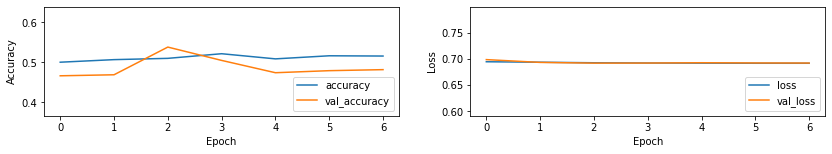

In [ ]:
MLP_model = Model_MLP_save_sorted[0][4]
history = Model_MLP_save_sorted[0][3]
y_pred_2 =predict(MLP_model,Model_MLP_save_sorted[0][5])
K.clear_session()
plot(history = history)

# f1 score y matriz de confusión MLP (TEST)

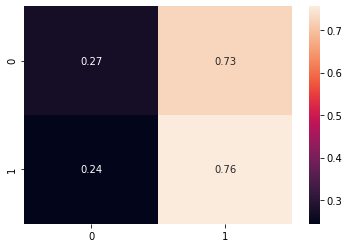

In [ ]:
y_pred_3 = predict(MLP_model,X_test_2, threshold = 0.506)
conf_mat = [0,0]
conf_mat[0] = confusion_matrix(y_test, y_pred_3)
conf_mat[1] = conf_mat[0].T / np.sum(conf_mat[0], axis = 1)
# Podemos usar seaborn para graficar esta matriz
sns.heatmap(conf_mat[1].T, annot = True)
plt.show()

In [ ]:
print(f1_score(y_test, y_pred_3,average='binary'),recall_score(y_test,y_pred_3,average='binary'),precision_score(y_test,y_pred_3,average = 'binary'))

0.609271523178808 0.75564681724846 0.5104022191400832


In [ ]:
a = np.squeeze(MLP_model.predict(X_test_2))

In [ ]:
b = np.array(a)
print(np.max(b),np.min(b),np.std(b))

0.5564996 0.49443504 0.010040729


(array([145., 438., 477., 546., 210.,  51.,  14.,  14.,  27.,  24.]),
 array([0.49443504, 0.5006415 , 0.506848  , 0.51305443, 0.5192609 ,
        0.52546734, 0.5316738 , 0.53788024, 0.5440867 , 0.55029315,
        0.5564996 ], dtype=float32),
 <a list of 10 Patch objects>)

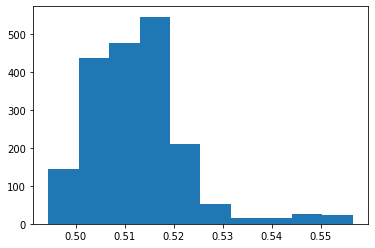

In [ ]:
plt.hist(b)

# Rangos susceptibilidad MLP

In [ ]:
#Mapeo de susceptibilidad EN BASE A FP Y FN
Mapeo = {}
for i in range(48,57,1):
  i = round(i/100,4)
  threshold = round(i,4)
  y_pred_3 = predict(MLP_model,X_test_2,threshold= threshold)
  conf_mat = [0,0]
  conf_mat[0] = confusion_matrix(y_test, y_pred_3)
  conf_mat[1] = conf_mat[0].T / np.sum(conf_mat[0], axis = 1)
  Mapeo['{}'.format(round(threshold,2))] = (round(conf_mat[1][0][1],2), round(conf_mat[1][1][0],2), round(f1_score(y_test,y_pred_3,average='binary'),2))
print('      FN   FP  f1_score')
for i in Mapeo:
  print('{}:{}'.format(i,Mapeo[i]))

      FN   FP  f1_score
0.48:(0.0, 1.0, 0.67)
0.49:(0.0, 1.0, 0.67)
0.5:(0.06, 0.94, 0.65)
0.51:(0.41, 0.57, 0.54)
0.52:(0.84, 0.16, 0.24)
0.53:(0.96, 0.05, 0.07)
0.54:(0.97, 0.04, 0.05)
0.55:(0.99, 0.02, 0.01)
0.56:(1.0, 0.0, 0.0)


# Optimización hiperparámetros MLP, propuesta

In [ ]:
def hyperband():
   return kt.oracles.Hyperband(
    objective=kt.Objective("f1_score", direction="max"),
    max_epochs= 20,
    factor=2,
    hyperband_iterations=1,
    seed=None)  

def bayesian():
   return kt.oracles.BayesianOptimization(
    objective=kt.Objective("f1_score", direction="max"),
    max_trials=20,
    seed = None)

def random():
   return kt.oracles.RandomSearch(
    objective=kt.Objective("f1_score", direction="max"),
    max_trials=10,
    seed=None,
    hyperparameters=None,
    allow_new_entries=True,
    tune_new_entries=True,)

In [ ]:
class CVTuner2(kt.engine.tuner.Tuner):

  def run_trial(self, trial, x, y, batch_size=32, epochs=1):
    cv = sklearn.model_selection.KFold(5,shuffle = True, random_state = 0)
    f1_scores = []
    h = 0
    for train_indices, test_indices in cv.split(x):
        x_train, x_test = x[train_indices], x[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        model = self.hypermodel.build(trial.hyperparameters)

        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 0)
        y_pred = model.predict(x_test)
        K.clear_session()
        y_pred = np.where(y_pred >= 0.5,1,0)
        #val_losses.append(model.evaluate(x_test, y_test))
        f1 = f1_score(y_test,y_pred,average = 'binary')
        f1_scores.append(f1)
        print("FOLD: {}, : f1_score: {}".format(h+1,f1))
        h+=1

    self.oracle.update_trial(trial.trial_id, {'f1_score': np.mean(f1_scores)})
    self.save_model(trial.trial_id, model)


best_MLP2 = []
#with tf.device('cpu:0'):
for batch in [16,32,64]:
  MLP2_tuner = CVTuner2(
  hypermodel=model_builder5,
  oracle=random(),
    directory='MLP_FINAL_{}'.format(batch+4),
    project_name='9'
    )
  MLP2_tuner.search(X_train_2, y_train, batch_size=batch, epochs=5)
  best_MLP2.append(MLP2_tuner.get_best_hyperparameters(num_trials=1))


Trial 10 Complete [00h 00m 07s]
f1_score: 0.5938722089754247

Best f1_score So Far: 0.5966534063232332
Total elapsed time: 00h 01m 24s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hpsss = []
BATCH = [16,32,64]
for i,hyperparameters in enumerate(best_MLP2):
  folds_top3 = []
  for train_indices, test_indices in cv.split(X_train_2):
      x_train__, x_val__ = X_train_2[train_indices], X_train_2[test_indices]
      y_train__, y_val__ = y_train[train_indices], y_train[test_indices]

      model_top3 = MLP2_tuner.hypermodel.build(hyperparameters[0])
      history_top3 = model_top3.fit(x_train__, y_train__, validation_data = (x_val__,y_val__),epochs=50,callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)],batch_size=BATCH[i], verbose = 0)

      y_pred = predict(model_top3,x_val__)
      K.clear_session()
      f1 = f1_score(y_val__,y_pred,average='binary')
      folds_top3.append(f1)
  mean = np.mean(folds_top3)
  best_hpsss.append((hyperparameters,mean,BATCH[i]))


best_hpss4 = sorted(best_hpsss,reverse=True, key=lambda best_hpsss: best_hpsss[1])

In [ ]:
#CROSSVALIDATION PARA LOS 3 BATCHSIZES
for i in range(3):
  print(best_hpss4[i][0][0].get('Optimizer'),
        best_hpss4[i][0][0].get('learning_rate'),
        best_hpss4[i][0][0].get('dropout'),
        best_hpss4[i][0][0].get('L1'),
        best_hpss4[i][0][0].get('L2'),
        best_hpss4[i][0][0].get('Neuronas'),
        best_hpss4[i][0][0].get('Layers'),
        best_hpss3[i][2],
        best_hpss3[i][1]

  )

Adam 0.001 0.2 0.0 0.0 64 5 16 0.5552404641776031
Adam 0.001 0.0 0.001 0.01 64 5 64 0.5546099154851701
SGD 0.0001 0.0 0.1 0.001 32 6 32 0.46621857485260376


In [ ]:
best_batch3 = best_hpss4[0][2]
Final_f1scores_MLP2 = []
Model_MLP2_save = []
ACC = []
VAL_ACC = []


cv = sklearn.model_selection.KFold(5,shuffle = True, random_state = 0)
for i in range(0,3):

  for train_indices, test_indices in cv.split(X_train_2):
      x_train__, x_val__ = X_train_2[train_indices], X_train_2[test_indices]
      y_train__, y_val__ = y_train[train_indices], y_train[test_indices]
      MLP2_model = MLP2_tuner.hypermodel.build(best_hpss4[0][0][0])
      history = MLP2_model.fit(x_train__, y_train__, validation_data = (x_val__,y_val__),epochs=50,batch_size=best_batch3,callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)], verbose = 0)
      Accuracy = history.history['accuracy'][-1]
      val_Accuracy = history.history['val_accuracy'][-1]
      y_pred = predict(MLP_model,x_val__)
      K.clear_session()
      f1 = f1_score(y_val__,y_pred,average='binary')
      Model_MLP_save.append((f1,Accuracy,val_Accuracy, history,MLP_model,x_val__,y_val__))

      ACC.append(Accuracy)
      VAL_ACC.append(val_Accuracy)
      Final_f1scores_MLP2.append(f1)
  
 

F1 = np.array(Final_f1scores_MLP2)
ACC = np.array(ACC)
VAL_ACC = np.array(VAL_ACC)


mean_train_MLP = np.mean(ACC)
std_train_MLP = np.std(ACC)
mean_val_MLP = np.mean(VAL_ACC)
std_val_MLP = np.std(VAL_ACC)
mean_f1_MLP = np.mean(F1)
std_f1_MLP = np.std(F1)


print(mean_train_MLP,std_train_MLP,mean_val_MLP,std_val_MLP)
print(mean_f1_MLP,std_f1_MLP)   


Model_MLP2_save_sorted = sorted(Model_MLP_save,reverse=True, key=lambda Model_MLP_save: Model_MLP_save[0])
Best_model_MLP2_save = Model_MLP_save_sorted[0]

0.5069362799326579 0.013730692569068297 0.5090923527876536 0.026635323798197132
0.6617831320936183 0.021772273210579958


In [ ]:
print(Model_MLP2_save_sorted[0][0])
print(Model_MLP2_save_sorted[0][1])
print(Model_MLP2_save_sorted[0][2])
print(Model_MLP2_save_sorted[0][3])
print(Model_MLP2_save_sorted[0][4])
print(Model_MLP2_save_sorted[0][5].shape)
print(Model_MLP2_save_sorted[0][6].shape)


0.6818980667838312
0.5215157270431519
0.5655527114868164
(389, 20)
(389,)


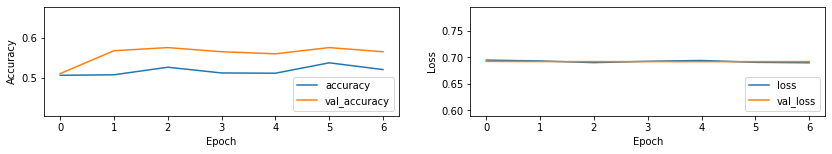

In [ ]:
MLP2_model = Model_MLP2_save_sorted[0][4]
history = Model_MLP2_save_sorted[0][3]
y_pred_2 =predict(MLP2_model,Model_MLP2_save_sorted[0][5])
K.clear_session()
plot(history = history)

# f1 score y matriz de confusión MLP propuesta (TEST)

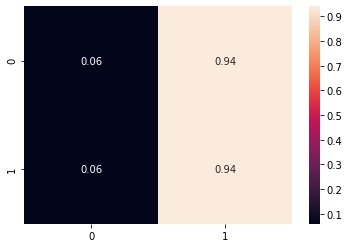

In [ ]:
y_pred_5 = predict(MLP2_model,X_test_2)
conf_mat = [0,0]
conf_mat[0] = confusion_matrix(y_test, y_pred_3)
conf_mat[1] = conf_mat[0].T / np.sum(conf_mat[0], axis = 1)
# Podemos usar seaborn para graficar esta matriz
sns.heatmap(conf_mat[1].T, annot = True)
plt.show()

In [ ]:
print(f1_score(y_test, y_pred_5,average='binary'),recall_score(y_test,y_pred_5,average='binary'),precision_score(y_test,y_pred_5,average = 'binary'))

0.6533523537803139 0.9404517453798767 0.5005464480874317


In [ ]:
a = np.squeeze(MLP2_model.predict(X_test_2))

In [ ]:
b = np.array(a)
print(np.max(b),np.min(b),np.std(b))

0.5564996 0.49443504 0.010040729


(array([145., 438., 477., 546., 210.,  51.,  14.,  14.,  27.,  24.]),
 array([0.49443504, 0.5006415 , 0.506848  , 0.51305443, 0.5192609 ,
        0.52546734, 0.5316738 , 0.53788024, 0.5440867 , 0.55029315,
        0.5564996 ], dtype=float32),
 <a list of 10 Patch objects>)

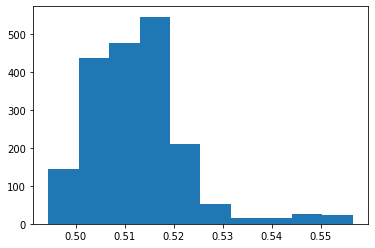

In [ ]:
plt.hist(b)